## 实验目标

预测葡萄酒产地

## 开发准备

In [1]:
# %% 下载数据集
!chcp 936
!aria2c --quiet http://labfile.oss.aliyuncs.com/courses/1029/wine.csv
%ls

活动代码页: 936
 驱动器 E 中的卷是 Public
 卷的序列号是 2D70-3901

 E:\Repository\TensorFlow\src\前向神经网络 的目录

2021/11/23  15:51    <DIR>          .
2021/11/23  15:51    <DIR>          ..
2021/11/23  15:38    <DIR>          .ipynb_checkpoints
2021/11/23  14:29            17,727 mpg.csv
2021/11/23  15:51            10,889 wine.csv
2021/11/23  14:16            64,336 非线性模拟数据回归.ipynb
2021/11/23  15:51             3,665 葡萄酒分类.ipynb
2021/11/23  15:01           140,344 汽车燃料效率建模.ipynb
               5 个文件        236,961 字节
               3 个目录 1,625,619,480,576 可用字节


## 分析流程

In [2]:
# %% 引入依赖项
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import preprocessing

In [3]:
# %% 配置 Matplotlib
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 96
plt.rcParams['figure.figsize'] = (16, 9)

In [4]:
# %% 加载数据集
dataset = pd.read_csv('./wine.csv', header=0)
dataset.describe()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


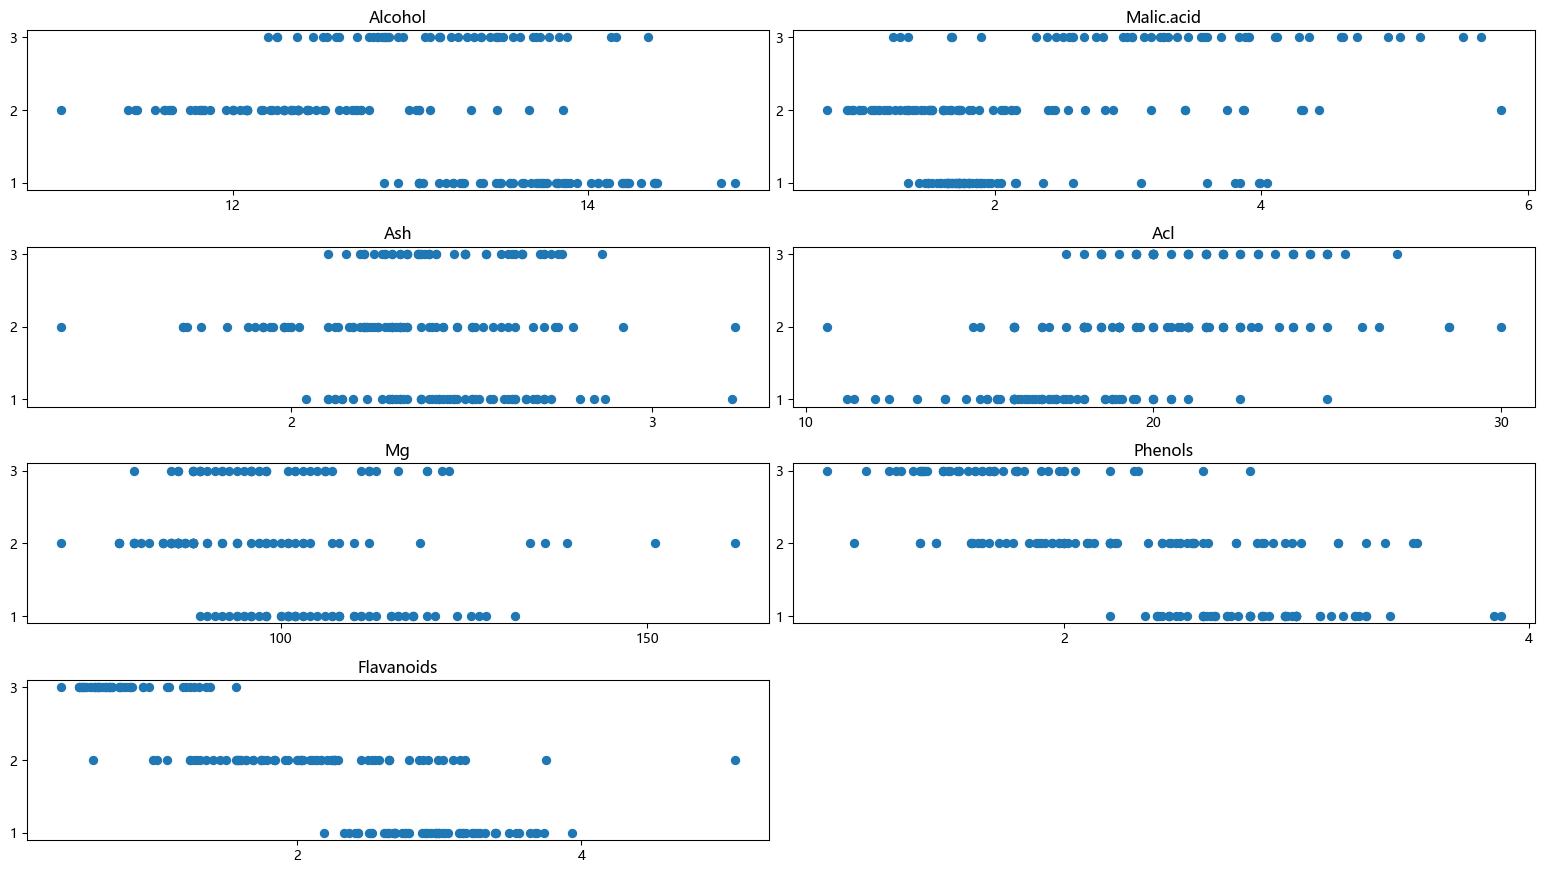

In [5]:
# %% 特征可视化
for i in range(1, 8):
    axes = plt.subplot(4, 2, i)
    axes.locator_params(nbins=3)
    plt.title(dataset.columns[i])
    axes.scatter(dataset.iloc[:, i], dataset.loc[:, 'Wine'])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [6]:
# %% 数据预处理
X = dataset.iloc[:, 1:13].values
Y = dataset.loc[:, 'Wine'].values - 1
X, Y = shuffle(X, Y)
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# %% 设计模型
class Linear(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = tf.keras.layers.Dense(
            units=3,
            activation='softmax',
            kernel_initializer=tf.zeros_initializer(),
            bias_initializer=tf.zeros_initializer())

    def call(self, inputs):
        output = self.dense(inputs)
        return output

In [8]:
# %% 构建模型
tf.keras.backend.set_floatx('float64')
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [10]:
# %% 训练模型
for i in range(100):
    X, Y = shuffle(X, Y, random_state=1)
    X_train, Y_train, X_test, Y_test = X[:140, :], Y[:140], X[140:178, :], Y[140:178]
    X_train, Y_train = shuffle(X_train, Y_train, random_state=0)
    with tf.GradientTape() as tape:
        y_pred = model(X_train)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=Y_train, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    y_pred_test = model.predict(X_test)
    sparse_categorical_accuracy.update_state(y_true=Y_test, y_pred=y_pred_test)
    print(f'Test Accuracy: {sparse_categorical_accuracy.result()}')

Test Accuracy: 0.8947368421052632
Test Accuracy: 0.9210526315789473
Test Accuracy: 0.9210526315789473
Test Accuracy: 0.9078947368421053
Test Accuracy: 0.9052631578947369
Test Accuracy: 0.9035087719298246
Test Accuracy: 0.8984962406015038
Test Accuracy: 0.9013157894736842
Test Accuracy: 0.9064327485380117
Test Accuracy: 0.9105263157894737
Test Accuracy: 0.9114832535885168
Test Accuracy: 0.9078947368421053
Test Accuracy: 0.9068825910931174
Test Accuracy: 0.9060150375939849
Test Accuracy: 0.9035087719298246
Test Accuracy: 0.899671052631579
Test Accuracy: 0.9024767801857585
Test Accuracy: 0.9049707602339181
Test Accuracy: 0.907202216066482
Test Accuracy: 0.9105263157894737
Test Accuracy: 0.9110275689223057
Test Accuracy: 0.9126794258373205
Test Accuracy: 0.9107551487414187
Test Accuracy: 0.9100877192982456
Test Accuracy: 0.9126315789473685
Test Accuracy: 0.9129554655870445
Test Accuracy: 0.9132553606237817
Test Accuracy: 0.9144736842105263
Test Accuracy: 0.9156079854809437
Test Accuracy: 0